In [ ]:
format ELF executable
entry _start

segment readable executable

_start:
    mov ebp, esp
    
main_loop:
    ; Вывод приглашения
    mov eax, 4
    mov ebx, 1
    mov ecx, prompt
    mov edx, prompt_len
    int 0x80
    
    ; Чтение ввода
    mov eax, 3
    mov ebx, 0
    mov ecx, input
    mov edx, 255
    int 0x80
    
    ; Проверка на EOF (когда ввод из pipe)
    test eax, eax
    jz exit_program
    
    ; Проверка на пустую строку
    cmp eax, 1
    jle main_loop
    
    ; Убираем символ новой строки
    mov esi, input
    add esi, eax
    dec esi
    mov byte [esi], 0
    
    ; Проверка на exit
    mov edi, input
    cmp byte [edi], 'e'
    jne .not_exit
    cmp byte [edi+1], 'x'
    jne .not_exit
    cmp byte [edi+2], 'i'
    jne .not_exit
    cmp byte [edi+3], 't'
    jne .not_exit
    cmp byte [edi+4], 0
    je exit_program
    
.not_exit:
    ; Создаем дочерний процесс
    mov eax, 2
    int 0x80
    
    test eax, eax
    jz .child_process
    
    ; Родительский процесс - ждем завершения
    push eax
    mov eax, 7
    pop ebx
    mov ecx, 0
    mov edx, 0
    int 0x80
    
    jmp main_loop

.child_process:
    ; Загружаем программу
    mov eax, 11
    mov ebx, input
    mov ecx, 0
    mov edx, 0
    int 0x80
    
    ; Если дошли сюда - ошибка
    mov eax, 1
    mov ebx, 1
    int 0x80

exit_program:
    mov eax, 1
    mov ebx, 0
    int 0x80

segment readable writeable
    prompt db "Введите команду: ", 0
    prompt_len = $ - prompt
    input rb 256

In [ ]:
format ELF executable
entry _start

segment readable executable

_start:
    ; Получаем PID для инициализации RNG и определения задачи
    mov eax, 20
    int 0x80
    mov [rseed], eax
    and eax, 3
    mov [task_id], eax
    
    ; Заполняем массив случайными числами
    mov ecx, array_size
    mov edi, numbers
.fill_loop:
    call rand
    mov [edi], eax
    add edi, 4
    loop .fill_loop
    
    ; Выполняем задачу в соответствии с task_id
    mov eax, [task_id]
    cmp eax, 0
    je task1
    cmp eax, 1
    je task2
    cmp eax, 2
    je task3
    cmp eax, 3
    je task4

task1:
    call find_most_frequent
    mov [result], eax
    mov ecx, msg1
    mov edx, msg1_len
    jmp output_result

task2:
    call count_mult5
    mov [result], eax
    mov ecx, msg2
    mov edx, msg2_len
    jmp output_result

task3:
    call quantile75
    mov [result], eax
    mov ecx, msg3
    mov edx, msg3_len
    jmp output_result

task4:
    call fifth_after_min
    mov [result], eax
    mov ecx, msg4
    mov edx, msg4_len

output_result:
    ; Сначала выводим сообщение
    call print_str
    ; Затем выводим число
    mov eax, [result]
    call print_number
    ; И новую строку
    call print_nl
    
    ; Завершаем процесс
    mov eax, 1
    mov ebx, 0
    int 0x80

; ========== ФУНКЦИИ ==========

rand:
    mov eax, [rseed]
    mov edx, 1103515245
    mul edx
    add eax, 12345
    mov [rseed], eax
    shr eax, 16
    and eax, 32767
    ret

find_most_frequent:
    mov ecx, 10
    mov edi, digit_count
    xor eax, eax
    rep stosd
    
    mov ecx, array_size
    mov esi, numbers
.count_loop:
    mov eax, [esi]
    add esi, 4
    test eax, eax
    jz .next_num
    
.digit_loop:
    xor edx, edx
    mov ebx, 10
    div ebx
    inc dword [digit_count + edx*4]
    test eax, eax
    jnz .digit_loop
    
.next_num:
    loop .count_loop
    
    mov ecx, 9
    mov eax, 0
    mov ebx, [digit_count]
    
.find_max:
    mov edx, [digit_count + ecx*4]
    cmp edx, ebx
    jle .next
    mov ebx, edx
    mov eax, ecx
.next:
    loop .find_max
    ret

count_mult5:
    mov ecx, array_size
    mov esi, numbers
    xor eax, eax
    
.loop:
    mov ebx, [esi]
    add esi, 4
    test ebx, ebx
    jz .skip
    
    push eax
    mov eax, ebx
    xor edx, edx
    mov ebx, 5
    div ebx
    pop eax
    test edx, edx
    jnz .skip
    
    inc eax
.skip:
    loop .loop
    ret

quantile75:
    call sort_array
    mov eax, array_size
    mov ebx, 3
    mul ebx
    shr eax, 2
    mov esi, numbers
    mov eax, [esi + eax*4]
    ret

fifth_after_min:
    call sort_array
    mov esi, numbers
    mov eax, [esi + 5*4]
    ret

sort_array:
    mov ecx, array_size
    dec ecx
    jle .done
    
.outer:
    push ecx
    mov esi, numbers
    xor edx, edx
    
.inner:
    mov eax, [esi]
    mov ebx, [esi+4]
    cmp eax, ebx
    jle .no_swap
    mov [esi], ebx
    mov [esi+4], eax
    mov edx, 1
.no_swap:
    add esi, 4
    loop .inner
    
    pop ecx
    test edx, edx
    jz .done
    loop .outer
.done:
    ret

print_str:
    mov eax, 4
    mov ebx, 1
    int 0x80
    ret

print_number:
    mov edi, num_buf + 11
    mov byte [edi], 0
    mov ebx, 10
    
    test eax, eax
    jnz .convert
    dec edi
    mov byte [edi], '0'
    jmp .print
    
.convert:
    xor edx, edx
    div ebx
    add dl, '0'
    dec edi
    mov [edi], dl
    test eax, eax
    jnz .convert
    
.print:
    mov ecx, edi
    mov edx, num_buf + 12
    sub edx, ecx
    mov eax, 4
    mov ebx, 1
    int 0x80
    ret

print_nl:
    mov ecx, nl
    mov edx, 1
    call print_str
    ret

segment readable writeable
    array_size = 100
    numbers rd array_size
    digit_count rd 10
    rseed rd 1
    task_id rd 1
    result rd 1
    num_buf rb 12
    
    msg1 db "Наиболее часто встречающаяся цифра: ", 0
    msg1_len = $ - msg1
    
    msg2 db "Количество чисел кратных пяти: ", 0
    msg2_len = $ - msg2
    
    msg3 db "0.75 квантиль: ", 0
    msg3_len = $ - msg3
    
    msg4 db "Пятое после миниманого: ", 0
    msg4_len = $ - msg4
    
    nl db 10

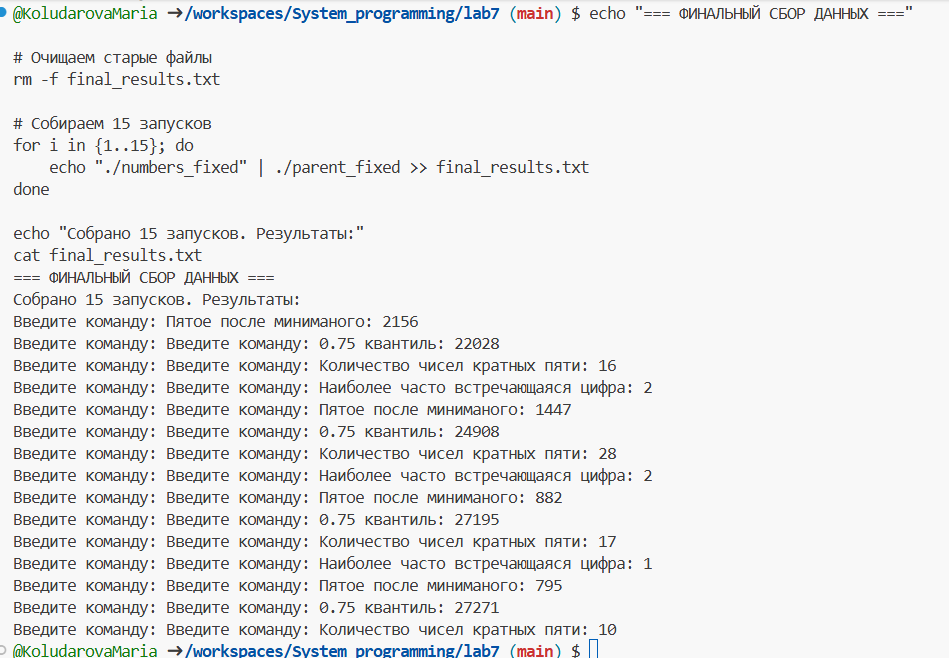